<div style="font-size:30pt; line-height:25pt; font-weight:bold; text-align:center;">When, where and how to add new neurons to ANNs </div>


# Introduction

Neural networks have come a long way, especially deep models with lots of neurons. Most of these models have a fixed structure, meaning we decide on the number of neurons in each layer before training and then tweak the parameters based on the dataset.

However, there's a new approach in deep learning that's all about **dynamic networks**. Unlike the fixed ones, dynamic networks not only learn parameters during training but can also change their structure as they learn.

This shift to dynamic networks has some advantages. It makes training more efficient and eliminates the need for manual tweaking of architectures. Dynamic networks can adapt to new information and tasks easily. They can even add or remove parts like neurons and connections as needed.

This notebook is about understanding dynamic networks, focusing on a specific idea called **structural pruning**. This process involves selectively removing connections or neurons, showing a bit of a concept called neurogenesis. Neurogenesis is like adding new elements within existing layers. Structural pruning, as you'll see in this notebook, is an example that highlights how dynamic networks can keep evolving and improving.

# Artificial Neural Networks (ANNs)

First, let's make a short reminder about Artificial Neural Networks.

Artificial Neural Networks (ANNs) represent a class of computational models inspired by the neural architecture of the human brain. Operating as interconnected nodes organized into layers, ANNs leverage a combination of linear and non-linear transformations to capture complex relationships within data.

At their core, ANNs consist of an input layer, one or more hidden layers, and an output layer. Each connection between nodes is associated with a weight, and the network learns by adjusting these weights during a training phase. The training process involves minimizing a predefined loss function, typically through optimization algorithms like stochastic gradient descent (SGD).

Activation functions introduce non-linearities into the network, enabling the modeling of intricate mappings between inputs and outputs. Common activation functions include Rectified Linear Units (ReLU), Sigmoid, and Hyperbolic Tangent (tanh), each influencing the network's capacity to capture and propagate information through the layers..

Training large-scale ANNs requires careful consideration of hyperparameters, such as learning rates, batch sizes, and regularization techniques to prevent overfitting.

You can find more information and detail on **[this github](https://github.com/SupaeroDataScience/deep-learning)**

<center><img src="img\ann.png" width="600px"></img></center>

## Time to code !! ##

Let's make a little ANN to classify the **[MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database)**. The MNIST dataset is composed of a collection of handwritten digit images, MNIST stands as a foundational resource for training and evaluating algorithms designed to recognize and classify digits from 0 to 9.
Each image in the MNIST dataset is a grayscale, 28x28-pixel representation of a handwritten digit.

**We will use Pytorch but you can do the same thing with Keras**

First, let's load the data and print 9 random figures :

In [7]:
# Import the necessary libraries

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim



In [8]:
# We need a, image transform to convert to Tensor and normalize with a mean of 0.5 and standard deviation of 0.5
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

# Download the Train and Test set

trainset = datasets.MNIST('.', train=True, download=True, transform=transform)
testset = datasets.MNIST('.', train=False, download=True, transform=transform)

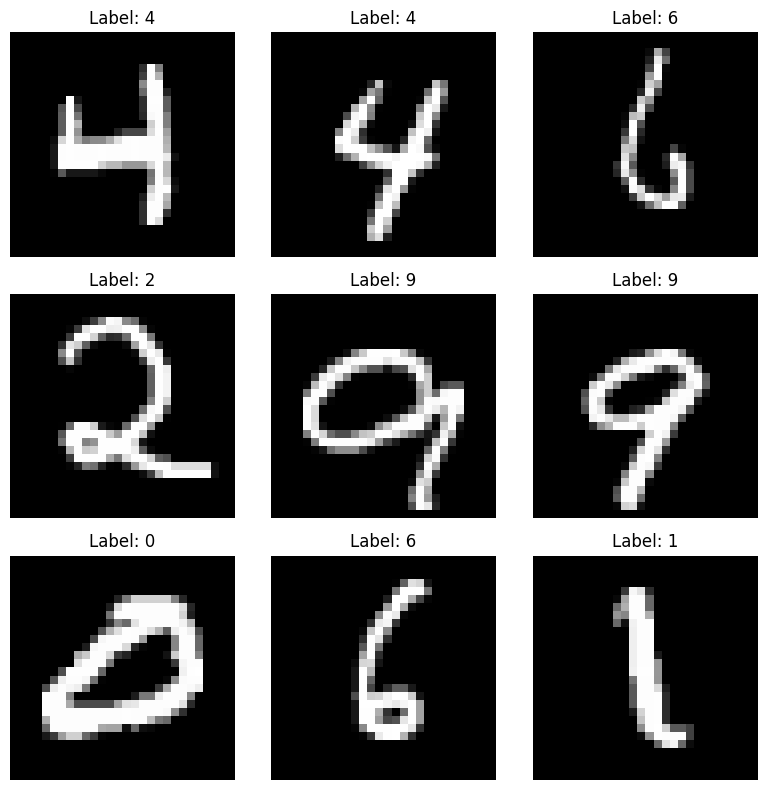

In [9]:
# Set up a 3x3 grid for displaying the images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

# Get 9 random indices from the training set
random_indices = np.random.choice(len(trainset), size=9, replace=False)

# Display the 9 random images
for i, idx in enumerate(random_indices):
    image, label = trainset[idx]
    image = image.numpy().squeeze()
    
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Parameters for the dataloader
batch_size = 64
valid_size = 0.2

In [11]:
# Split the training set into training and validation sets
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define the samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [12]:
# Create the dataloaders
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)

Now that we have prepared the data, we can implement a little ANN, with 2 hidden layers to classify the figures.

In [13]:
# Parameters for the model
nb_epochs = 10
lr = 0.001

In [36]:
# Model architecture of the neural network fully connected

class ANN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_1, hidden_layer_2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_layer_1, bias=False), 
            nn.ReLU(),
            nn.Linear(hidden_layer_1, hidden_layer_2, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_layer_2, output_size, bias=False),
            nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.network(x)

# Create the model
input_size = 28*28
output_size = 10
hidden_layer_1 = 512
hidden_layer_2 = 512

model_ann = ANN(input_size, output_size, hidden_layer_1, hidden_layer_2)

# Define the loss function and the optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_ann.parameters(), lr=lr)
print(model_ann)

ANN(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=False)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=False)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=False)
    (5): LogSoftmax(dim=1)
  )
)


In [37]:
# Train the model
list_loss = []
for i in tqdm(range(nb_epochs),desc="Training of the ANN"):
    model_ann.train()
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model_ann(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print(loss)
    list_loss.append(running_loss/len(train_loader))
    
    # print(f"Epoch nb {i+1}. Training loss: {running_loss/len(train_loader)}")

Training of the ANN:   0%|          | 0/10 [00:00<?, ?it/s]

Training of the ANN: 100%|██████████| 10/10 [05:41<00:00, 34.12s/it]


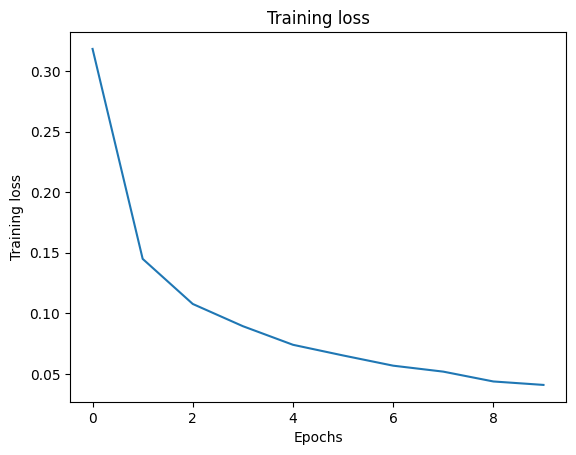

In [38]:
# Plot the training loss
plt.plot(list_loss)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Training loss')
plt.show()

In [39]:
# Test the model
model_ann.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in valid_loader:
        output = model_ann(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
torch.save(model_ann.state_dict(), 'model.pt')
print(f"Accuracy of the model on the validation set: {100 * correct / total:.2f}%")

Accuracy of the model on the validation set: 97.51%


# Structural pruning 

Now that we've established our neural network, consisting of two layers with 512 neurons each, we can explore techniques to prune it effectively. Pruning aims to streamline the network, reducing training and validation time without compromising performance. Among various pruning methods, two stand out as the most commonly used:

1. Weight pruning
2. Neuron pruning

Weight pruning involves removing connections between neurons by setting the corresponding weights to zero. Conversely, neuron pruning entails eliminating entire neurons by zeroing out all connections associated with the neuron being pruned. The distinction between these methods is illustrated in the image below.

<center><img src="img\Pruning image.webp" width="500px"></img></center>

We are going to see how weight pruning works

## Weight pruning

In the technique of weight pruning, we selectively remove connections within a neural network by setting individual weights in the weight matrix to zero. This process effectively sparsifies the network, reducing its complexity and potentially improving its efficiency during both training and inference stages.

The mechanism of weight pruning involves ranking the individual weights in the weight matrix $W$ based on their absolute value. By doing so, we obtain a sorted list of weights.

To achieve a desired level of sparsity, denoted as $k\%$, we then proceed to set to zero the smallest $k\%$ of weights from the sorted list. This corresponds to deleting a certain percentage of connections in the neural network, effectively reducing the number of parameters and connections within the model.

The degree of sparsity, represented by $k\%$, can be adjusted based on specific requirements or constraints. Higher values of $k\%$ result in more aggressive pruning, leading to greater sparsity but potentially at the expense of model performance. Conversely, lower values of $k\%$ preserve more connections and parameters, thus retaining more of the network's original capacity.

Now that we know how the weight pruning works, we can then write a pseudo code to implement it in Python :

```
for l in layers(model):
    Compute absolute values of all weights in W.
    Sort weights in ascending order based on their absolute values.
    Set to zero the smallest k% of weights.
    Replace the weight by the pruned weights in the matrix W.
```


We will rewrite the code implemented in Pytorch to understand how it works. We will use the useful fonctions and the skeleton class that you can find [here](https://github.com/pytorch/pytorch/blob/main/torch/nn/utils/prune.py). 

In [40]:
# Skeleton of the pruning class
from torch.nn.utils.prune import BasePruningMethod

# Some useful fonction to validate the pruning amount 
# If you want to see how they work, you can look at the link right above to have the full code
from torch.nn.utils.prune import _validate_pruning_amount_init, _validate_pruning_amount

To find the weights that need to be set at 0, we write a fonction that return the indices of the k first elements based on their values.

In [41]:
def weights_to_shut(input_tensor, k):
    # Flatten the input tensor
    flattened_input = input_tensor.flatten()

    # Use torch.sort to get the indices of the top k elements
    sorted_indices = torch.argsort(flattened_input)

    # Take the top k indices
    topk_indices = sorted_indices[:k]

    return topk_indices

In [42]:
class Weight_Pruning(BasePruningMethod):
    """Prune (currently unpruned) units in a tensor by zeroing out the ones with the lowest L1-norm.

    Args:
        amount (float): quantity of parameters to prune.
            It should be between 0.0 and 1.0 and represent the
            fraction of parameters to prune.
    """

    PRUNING_TYPE = "unstructured"

    def __init__(self, amount):
        # Check range of validity of pruning amount
        _validate_pruning_amount_init(amount)
        self.amount = amount

    def compute_mask(self, t, default_mask):

        # t is the tensor to prune, meaning the weights of the layer
        # Check that the amount of units to prune is not > than the number of
        # parameters in t
        tensor_size = t.nelement()

        # Compute number of units to prune: amount * tensor_size
        nparams_toprune = round(self.amount * tensor_size)

        # This should raise an error if the number of units to prune is larger
        # than the number of units in the tensor
        _validate_pruning_amount(nparams_toprune, tensor_size)

        # Create mask containing only ones
        mask = default_mask.clone(memory_format=torch.contiguous_format)

        if nparams_toprune != 0:  # k=0 not supported by torch.kthvalue            
            # Compute the indices to zero out
            indices_at_0 = weights_to_shut(torch.abs(t).view(-1), k=nparams_toprune)
            # Set the elements to zero
            mask.view(-1)[indices_at_0] = 0

        return mask

    @classmethod
    def apply(cls, module, name, amount, importance_scores=None):
        r"""Add pruning on the fly and reparametrization of a tensor.

        Adds the forward pre-hook that enables pruning on the fly and
        the reparametrization of a tensor in terms of the original tensor
        and the pruning mask.

        Args:
            module (nn.Module): module containing the tensor to prune
            name (str): parameter name within ``module`` on which pruning
                will act.
            amount (int or float): quantity of parameters to prune.
                It should be between 0.0 and 1.0 and represent the
                fraction of parameters to prune.
            importance_scores (torch.Tensor): tensor of importance scores (of same
                shape as module parameter) used to compute mask for pruning.
                The values in this tensor indicate the importance of the corresponding
                elements in the parameter being pruned.
                If unspecified or None, the module parameter will be used in its place.
        """
        return super().apply(
            module, name, amount=amount, importance_scores=importance_scores
        )


In [44]:
import torch.nn.utils.prune as prune

list_accuracy_weight = []

for i in tqdm(range(20)):
    model = ANN(input_size, output_size, hidden_layer_1, hidden_layer_2)
    model.load_state_dict(torch.load('model.pt'))
    prune_l1 = Weight_Pruning(amount=i/20)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune_l1.apply(module, name='weight', amount=i/20)

    # Test the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            output = model(images)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    list_accuracy_weight.append(100 * correct / total)


100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


Let's plot the accuracy of the validation set against the sparsity to see how removing connections impact the performance of our neural network

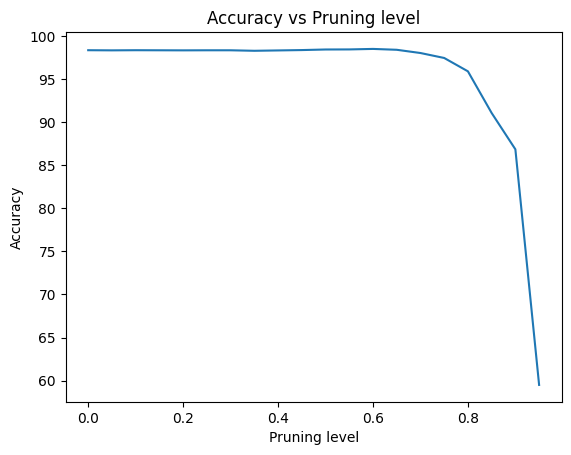

In [26]:
# Display the accuracy
plt.plot(1/20 * np.arange(20), list_accuracy_weight)
plt.xlabel('Pruning level')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Pruning level')
plt.show()

As observed, the act of pruning connections has a negligible impact on the model's performance until approximately 80% sparsity is achieved, indicating the removal of a significant portion of connections. This technique affords us the opportunity to substantially enhance performance, showcasing its efficacy in optimizing the model's efficiency without compromising its effectiveness. So we could change our model to a one with only 80% of neurons it will be barely the same performance.


# Neurogenesis

Now that we have seen how a dynamic neural network works, we can better understand how the neurogenesis works. We consider neurogenesis through the following dimensions about adding neurons:
 - **When**: Standard learning algorithms naturally discretize the learning process into steps, so
neurogenesis may occur at any step of training.
 - **How many**: When neurogenesis is triggered at a step, multiple neurons can be added at once.
 - **Where**: In standard ANN architectures, this amounts to which layer neurogenesis occurs in.
 - **How**: The fan-in and fan-out weights and bias of each new neuron must be initialized.
 

Existing neurogenesis research primarily focuses on **when** and **how** to initialize new neurons. Some studies delay neurogenesis until later in training, while others advocate for its occurrence throughout training. Recent approaches often use gradient-based methods to initialize new neurons, either by splitting existing neurons or creating entirely new ones based on gradient norms. Neurogenesis expands the parameter search space and can either preserve the network's function or alter it. To unify these approaches and study their components, we will see an a framework for neurogenesis strategies.

## Framework

The neurogenesis framework divides neurogenesis strategies into triggers, which are heuristics that determine when, where, and how many neurons to add, and initializations, which determine how to set their weights before training them. We present the basic framework below. After every gradient step, for each layer, the trigger is evaluated to determine if and how many neurons to add, and then the initialization is used to add these new neurons. Since the trigger is assessed after each gradient step, the decision of when to add neurons is based on non-zero outputs from the trigger. Similarly, the decision of where to add neurons is addressed by evaluating the trigger on each layer independently.

---
Neurogenesis framework


```{python}
Procedure Neurogenesis(Trigger, Initialization, initial ANN 𝑓)
    while 𝑓 not converged do
        Gradient descent step on current existing weights
        for each hidden layer 𝑙 do
            if Trigger(𝑓,𝑙) > 0 then
                Add Trigger(𝑓,𝑙) neurons using Initialization(𝑓,𝑙)
    return trained 𝑓
```
---

### Triggers


We will see three sources of information for trigger for neurogenesis : neural activations, weights, and gradients. These triggers determine if and how many neurons to add for each layer after each gradient step.

1. **Activation based** : When constructing an efficient network via neurogenesis, the aim is to add neurons that introduce novel features to improve the direction of descent, reduce empirical risk, or avoid redundancy. Thus, we need to measure how
different or orthogonal the post-activations are from each other. To measure orthogonality of a
layer, we use the 𝜖-numerical rank of the post-activation matrix. For layer 𝑙 and 𝑛 samples generating the post-activation $H_l$ the effective dimension metric may be estimated by: $$ \phi_a^{ED} (f,l) = \frac{1}{M_l} \bigg|\bigg\{\sigma \in \text{SVD}\bigg(\frac{1}{\sqrt{n}} H_l\bigg)\bigg| \sigma > \epsilon \bigg\}\bigg| $$ Where $\text{SVD}\bigg(\frac{1}{\sqrt{n}} H_l\bigg)$ is the set of singular value of $\frac{1}{\sqrt{n}} H_l$, $\epsilon > 0$ is a small threshold and $M_l$ is the number of rows of the matrix $W_l$, equivalent to the number of entries of the layer $l$. This metric estimates the effective dimension of post-activation matrices, indicating potential for adding new neurons when orthogonality is high and redundancy when it's low. The addition of a new neuron increases the metric if its activation is more orthogonal to others and decreases it if it's redundant. The baseline metric value at network initialization guides the process, aiming to maintain or increase it throughout training. The number of neurons triggered is based on the difference between the current metric value and a threshold, scaled by the current number of neurons.\
Now that we have a metric the goal is to preserve this initial metric value throughout training, even as the layer expands. If new neurons fail to increase the rank and decrease the metric value, neurogenesis pauses until the rank improves through gradient descent. This baseline value is multiplied by a threshold hyperparameter $\gamma_a$ close to 1. The number of triggered neurons is then : $$  T_{act}(f, \phi_a, l) = \min(0, \lfloor{M_l(\phi_a(f, l) - \gamma_a \phi_a(f_0, l))}\rfloor) $$ where $f_0$ is the ANN at initialization and $\phi_a$ is the orthogonality metric.

2. **Weight based** : We include weight matrix orthogonality as a comparison to activation-based methods. The trigger, $T_weight$ , is computed as in the two equations in the activation based but with $W_l$ instead of $H_l$ : $$\phi_w^{ED} (f,l) = \frac{1}{M_l} \bigg|\bigg\{\sigma \in \text{SVD}\bigg(\frac{1}{\sqrt{n}} W_l\bigg)\bigg| \sigma > \epsilon \bigg\}\bigg|$$ $$ T_{weight}(f, \phi_w, l) = \min(0, \lfloor{M_l(\phi_w(f, l) - \gamma_w \phi_w(f_0, l))}\rfloor) $$

3. **Gradient based** : To investigate gradient-based neurogenesis initializations within dynamic neurogenesis, we will use a trigger based on the auxiliary gradient. This trigger assesses the maximum increase in gradient norm attainable by adding $k$ neurons to the $l\text{th}$ layer as the sum of the largest $k$ singular values of the auxiliary gradient matrix $\frac{\partial L}{\partial z_{l-1}} h_{l-1}$. By comparing these singular values with the gradient norms of all existing neurons in that layer over the same dataset, we determine the number of neurons to trigger based on the count of singular values exceeding the sum of gradient norms. $$ \phi_{grad} (f, L, l) = \frac{1}{M_l} \bigg|\bigg\{\sigma \in \text{SVD}\bigg(\frac{\partial{L}}{\partial{Z_{l+1}}} H_{l-1}^{\text{T}}\bigg)\bigg| \sigma > \sum_{m=1}^{M_l} \bigg| \bigg| \frac{\partial{L}}{\partial{w_{m}^{in}}}\bigg| \bigg|_F + \bigg| \bigg| \frac{\partial{L}}{\partial{w_{m}^{out}}}\bigg| \bigg|_F \bigg\}\bigg| $$ where $L$ is the loss function if the network, $w_m^{in}$ is the $m^{th}$ row of $W_l$ and $w_m^{out}$ is the $m^{th}$ column of $W_{l+1}$, respectively representing the fan-in and fan_out weight of the $m^{th}$ neuron of the layer $l$. We intuit this threshold creates neurons that could have initial gradients significantly stronger than existing neurons and will be harder to surpass as the layer grows, thus leading to convergence in layer width.

### Initializations

For the initialization of new neurons, we aim to minimize computational overhead by leveraging information already computed for the corresponding trigger in each method. Then, we introduce function-preserving neurons that do not immediately alter the network output or the activation of downstream layers. Our proposal suggests that the role of initialization during training neurogenesis is to add locally useful neurons to the triggered layer, which are subsequently integrated into the network's functionality via gradient descent. We assess the utility of these neurons based on activation, weights, and gradients. Additionally, we standardize the weight norm of new neurons to match that of existing neurons, simplifying subsequent calculations.

Note : The suite of neurogenesis strategies all begin with NORTH, that means Neural ORTHogonality for the initialization

1. **Activation based** : We present multiple approaches for initializing neurons to achieve orthogonal post-activations. However, due to the nonlinearity of neurons, closed-form solutions are only available for a set of fan-in weights, resulting in orthogonal pre-activations rather than post-activations. These approaches generate candidate neurons and select those that independently maximize the orthogonality metric of the post-activations with existing neurons in the layer. The fan-out weights are initialized to 0.
    - **_NORTH-Select_** : generate random candidate neurons.
    - **_NORTH-Pre_** : generate candidate neurons with pre-activations maximally orthogonal to existing
pre-activations. For $n$ samples and $M_l$ neurons in layer $l$ , a candidate’s fan-in weights are $$ \textbf{w} = (\textbf{H}^\intercal_{l-1})^{-1} \textbf{V}^{'}_{Z_l} \textbf{a}^{\intercal} $$ where $(\textbf{H}^\intercal_{l-1})^{-1}$ is the left inverse of the transpose of post-activations $H_{l-1}$ for layer $l-1$, $V^{'}_{Z_l}$ is comprised of orthogonal vectors of the kernel of pre-activations $Z_l$, and $a \in \mathbb{R}^{n-M_l}$ is a random vector resampled for each candidate.\
As a baseline to these selection-based techniques, **_NORTH-Random_** uses RandomInit as the initialization strategy with random fan-in weights and zeroed fan-out weights.

2. **Weight based** : The objective is to initialize $k$ new neurons with fan-out weights set to 0, while the fan-in weights are designed to be orthogonal to the existing weights in the layer. So, each new neuron is initialized with fan-out weights of 0 and fan-in weights determined by projecting random initial weights onto the kernel (null space) of the existing weight matrix $W_l$ : $$ \textbf{w} = \text{proj}_{\ker W_l} (\textbf{w}_i)$$ where $ \textbf{w}_i \in \mathbb{R}^{M_{l-1} + 1} $ are the random initial fan-in weights from the base weight initialization and the projection is computed using $V^{'}_{W_l}$ , comprised of orthogonal vectors of the kernel.It is named **_NORTH-Weight_**

3. **Gradient based** : For this initialization, a reimplementation of existing neurogenesis algorithm is used like NeST from [Dai et al. (2019)](https://arxiv.org/abs/1711.02017), [Firefly from Wu et al. (2020)](https://arxiv.org/abs/2102.08574), and [GradMax from Evci et al. (2022)](https://arxiv.org/abs/2201.05125)

**Quick recapitulatif of all the trigger and initialization**

| Strategy    | Trigger    | Initialization|
|-------------|   ----     |          --   |
| NORTH-Select| $T_{act}$  |Select         |
|NORTH-Pre    | $T_{act}$  | Pre-activation|
|NORTH-Random |$T_{act}$   | RandomInit    |
|NORTH-Weight |$T_{weight}$| Weight        |
|GradMax      |$T_{grad}$  | GradMax       |
|Firefly      |$T_{grad}$  | Firefly       |
|NeST         |$T_{grad}$  | NeST          |

## Experiments

We are now going to study the impact of the different trigger and initialization methods detailed in Table 1 over a variety of tasks, with dynamic schedules to study triggers and independently studying the importance of initialization by also using fixed schedules. We are also going to compare with static networks of various sizes to understand the relative performance of networks grown with neurogenesis. Specifically, we focus on MLPs on MNIST.

In our investigation of neurogenesis within dense MLP layers for MNIST classification, we utilize networks with vectorized image inputs, two hidden layers that grow via neurogenesis, and ten output neurons as we just saw before. We explore dynamic strategies and isolate initializations in preset growth schedules. Test accuracy and training time are compared against final network size or schedule, depicted in Figure 1, while Figure 2 illustrates layer widths over training for dynamic schedules.

To better understand the impact of trigger versus initialization methods, we compare different initialization approaches using fixed neurogenesis schedules. We employ two predefined schedules: Linear and Batched.

 - the **Linear** schedule adds one neuron per gradient step.
 - The **Batched** schedule adds batches of neurons after each gradient step.

Both schedules are characterized by initial and final layer widths. We allow neuron growth for the first 75% of epochs.

The **Linear** schedule results in frequent, small growth events as neurons are added one at a time.
The **Batched** schedule, on the other hand, has fewer, larger growth events as neurons are added in regular intervals.
We also compare these schedules with a Medium Static network, which begins training with the final size of the growing networks, containing 256 neurons per hidden layer.

<figure>
  <center><img src="img\training_time.png" width="700px" ></center>
  <figcaption style="text-align:center;">Figure 1</figcaption>
</figure>

<figure>
  <center><img src="img\figure2.png" width="700px" ></center>
  <figcaption style="text-align:center;">Figure 2</figcaption>
</figure>
Dynamic neurogenesis reveals that NORTH* orthogonality-based methods dominate the Pareto front of accuracy versus network size (the Pareto front of accuracy represents the trade-off between achieving higher accuracy and minimizing network size or complexity). These methods leverage activation and weight orthogonality triggers, outperforming gradient-based approaches like GradMax and NeST, despite the latter's faster CPU implementation due to optimized deep learning libraries for gradient descent. The triggers effectively converge toward smaller networks, responding to questions of "When" and "How many" neurons to add. NORTH* methods tend to converge toward networks with larger first layers and smaller second layers, resembling patterns in hand-designed networks. Preset schedules show that multiple NORTH* strategies outperform static networks of similar final architectures, highlighting the benefits of dynamically growing networks during learning. However, NORTH-Pre slightly underperformed compared to less-informed approaches, such as NORTH-Select and NORTH-Random, indicating the importance of trigger selection in neurogenesis strategies.

## Conclusion 

NORTH* strategies enable the development of efficient networks that achieve comparable performance to static architectures, and in some cases even outperform them. Utilizing growth with informed triggers leads to efficient networks as redundant neurons are less likely to be created during the small network initialization and are not added by NORTH* neurogenesis. Activation and weight orthogonality have been found to be useful triggers for dynamic neurogenesis, along with weight initializations of new neurons. These methods implicitly use gradient information via network updates, thus potentially extending to unsupervised and semi-supervised contexts where gradient information may be unreliable. While neurogenesis triggers can be computationally costly, NORTH* strategies have shown greater efficiency compared to gradient-based methods in GPU experiments.

We present the NORTH* suite of neurogenesis strategies, comprised of triggers that use orthogonality metrics of either activations or weights to determine when, where, and how many neurons to add and informed initializations that optimize the metrics. NORTH* strategies achieve dynamic neurogenesis, growing effective networks that converge in size and can outperform baseline static networks in compactness or performance. The orthogonality-based neurogenesis methods in NORTH* could be further used to grow networks in a variety of settings, such as continual learning, shifting distributions, or combined synergistically with other structural learning methods. Neurogenesis can grow network architectures that dynamically respond to learning.

# References

All inspired by [When, where, and how to add new neurons to ANNs](https://arxiv.org/abs/2202.08539)